In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:23<00:00, 148MB/s]
100% 2.29G/2.29G [00:23<00:00, 104MB/s]
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 656M/663M [00:11<00:00, 69.5MB/s]
100% 663M/663M [00:11<00:00, 59.6MB/s]


In [2]:
!unzip chest-xray-pneumonia.zip &> /dev/null
!unzip tuberculosis-tb-chest-xray-dataset.zip &> /dev/null

In [3]:
 !mv ./TB_Chest_Radiography_Database/Normal ./TB_Chest_Radiography_Database/NORMAL

In [4]:
!mv ./TB_Chest_Radiography_Database/Tuberculosis ./TB_Chest_Radiography_Database/TUBERCULOSIS

In [5]:
!rm ./TB_Chest_Radiography_Database/Normal.metadata.xlsx ./TB_Chest_Radiography_Database/README.md.txt ./TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx

In [6]:
data_chestxray_dir = "./chest_xray/chest_xray/"
data_chesttb_dir = "./TB_Chest_Radiography_Database/"

In [7]:
import os
import shutil
import random

# Paths to the original folders
classes_tbchest = ['NORMAL', 'TUBERCULOSIS']

# Paths for the new folders
base_dir_tbchest = 'chest_tb'
train_dir = os.path.join(base_dir_tbchest, 'train')
val_dir = os.path.join(base_dir_tbchest, 'val')
test_dir = os.path.join(base_dir_tbchest, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes_tbchest:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Function to split data
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)
    random.shuffle(files)

    train_size = int(len(files) * train_ratio)
    val_size = int(len(files) * val_ratio)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(train_dir, file))

    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(val_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(test_dir, file))

# Split each class
for cls in classes_tbchest:
    class_dir = os.path.join(data_chesttb_dir, cls)
    split_data(class_dir, os.path.join(train_dir, cls), os.path.join(val_dir, cls), os.path.join(test_dir, cls))

print("Dataset split completed!")

Dataset split completed!


In [8]:
data_chesttb_dir = "./chest_tb/"

In [11]:
import os
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms


def data_transforms(phase):
    # If the phase is TRAIN
    if phase == 'train':
        # Compose transformations: Resize, CenterCrop, Convert to Tensor, Normalize
        transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),  # Convert the image to a PyTorch Tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the Tensor
        ])

    # If the phase is VAL
    if phase == 'val':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == 'test':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform  # Return the composed transformations

image_datasets_chestxray = {x: datasets.ImageFolder(os.path.join(data_chestxray_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}
image_datasets_chesttb = {x: datasets.ImageFolder(os.path.join(data_chesttb_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}

new_class_to_idx_tb = {'NORMAL': 0, 'TUBERCULOSIS': 2}

# Function to remap the labels in a dataset
def remap_labels(dataset, new_class_to_idx):
    # Remap the targets
    dataset.targets = [new_class_to_idx[dataset.classes[label]] for label in dataset.targets]

    # Update class index in dataset.samples
    new_samples = []
    for path, label in dataset.samples:
        new_samples.append((path, new_class_to_idx[dataset.classes[label]]))
    dataset.samples = new_samples

    # Update the class_to_idx attribute
    dataset.class_to_idx = new_class_to_idx
    # Update the classes attribute
    dataset.classes = list(new_class_to_idx.keys())

# Apply the remapping to the chesttb datasets
for phase in ['train', 'val', 'test']:
    remap_labels(image_datasets_chesttb[phase], new_class_to_idx_tb)

In [12]:
print(image_datasets_chestxray['train'].class_to_idx)
print(len(image_datasets_chestxray['train']))

print(np.unique(image_datasets_chestxray['train'].targets, return_counts=True))

{'NORMAL': 0, 'PNEUMONIA': 1}
5216
(array([0, 1]), array([1341, 3875]))


In [13]:
print(image_datasets_chesttb['train'].class_to_idx)
print(len(image_datasets_chesttb['train']))

print(np.unique(image_datasets_chesttb['train'].targets, return_counts=True))

{'NORMAL': 0, 'TUBERCULOSIS': 2}
2939
(array([0, 2]), array([2450,  489]))


In [14]:
# Combine the datasets after remapping
image_datasets_combined = {
    x: torch.utils.data.ConcatDataset([image_datasets_chestxray[x], image_datasets_chesttb[x]])
    for x in ['train', 'val', 'test']
}

In [15]:
targets_combined = []

for dataset in image_datasets_combined['train'].datasets:
    targets_combined.extend(dataset.targets)

targets_combined = torch.tensor(targets_combined)

# Calculate class weights (inverse of class frequency)
class_counts = torch.bincount(targets_combined)
class_weights = 1.0 / class_counts.float()
print(f"Class weights: {class_weights}")

# Calculate sample weights based on class weights
sample_weights = class_weights[targets_combined]
print(f"Sample weights: {sample_weights}")

# Create WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class weights: tensor([0.0003, 0.0003, 0.0020])
Sample weights: tensor([0.0003, 0.0003, 0.0003,  ..., 0.0020, 0.0020, 0.0020])


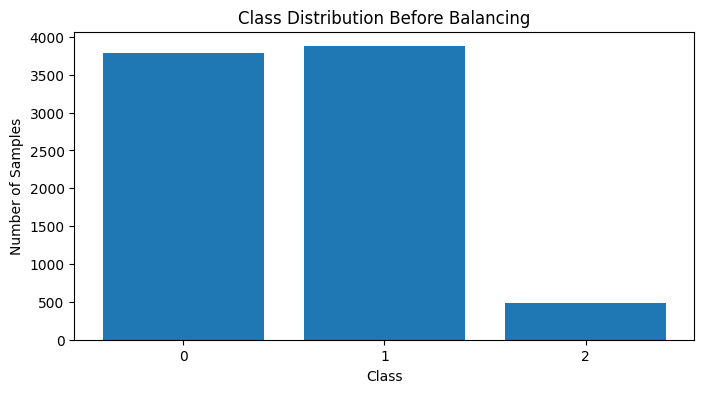

Class counts before balancing: [3791 3875  489]


In [16]:
import matplotlib.pyplot as plt

# Count the number of instances of each class before balancing
class_counts = torch.bincount(targets_combined)

# Plot the class distribution
plt.figure(figsize=(8, 4))
plt.bar(range(len(class_counts)), class_counts.numpy(), tick_label=list(range(len(class_counts))))
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts before balancing:", class_counts.numpy())

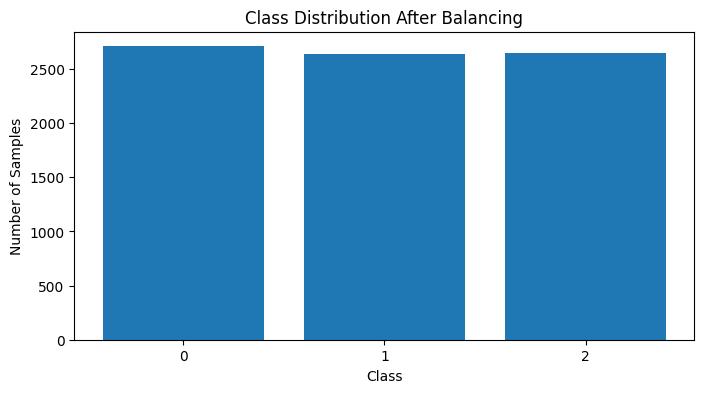

Class counts after balancing: [2709 2643 2648]


In [17]:
# Simulate sampling
num_samples_to_check = 8000  # You can increase this number for better accuracy
sampled_indices = list(sampler)[:num_samples_to_check]
sampled_targets = targets_combined[sampled_indices]

# Count the number of instances of each class after balancing
balanced_class_counts = torch.bincount(sampled_targets)

# Plot the class distribution after balancing
plt.figure(figsize=(8, 4))
plt.bar(range(len(balanced_class_counts)), balanced_class_counts.numpy(), tick_label=list(range(len(balanced_class_counts))))
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts after balancing:", balanced_class_counts.numpy())

In [18]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets_combined['train'], batch_size = 32, sampler=sampler),
    'val': torch.utils.data.DataLoader(image_datasets_combined['val'], batch_size = 32),
    'test': torch.utils.data.DataLoader(image_datasets_combined['test'], batch_size = 32)
}

In [19]:
len(dataloaders['train'])

255

In [26]:
# Load pre-trained ResNet-18
model = models.resnet50(weights='DEFAULT')

# Modify the final layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 100MB/s]


In [27]:
print(f"Number of Model Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Memmory Usage: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")



Number of Model Parameters: 23514179
Memmory Usage: 0.24 GB


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Initialize dictionaries to store metrics
metrics = {
    'train_loss': [],
    'train_acc': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

# Parameters for Early Stopping
early_stopping_patience = 5  # Stop after 5 epochs with no improvement
best_val_loss = float('inf')
patience_counter = 0

num_epochs = 100  # Set a higher number of epochs to allow early stopping

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = dataloaders['train']
        else:
            model.eval()  # Set model to evaluate mode
            dataloader = dataloaders['val']

        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []

        # Iterate over data with tqdm progress bar
        for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # Backward pass + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Store labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        # Calculate metrics
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Save metrics
        metrics[f'{phase}_loss'].append(epoch_loss)
        metrics[f'{phase}_acc'].append(epoch_acc.item())
        metrics[f'{phase}_precision'].append(epoch_precision)
        metrics[f'{phase}_recall'].append(epoch_recall)
        metrics[f'{phase}_f1'].append(epoch_f1)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}')

        # Early stopping check during validation phase
        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                patience_counter = 0  # Reset the counter if improvement occurs
                # Save the model weights when improvement occurs
                torch.save(model.state_dict(), '/content/drive/MyDrive/best_model.pth')
            else:
                patience_counter += 1

    print()

    # Check for early stopping
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Specify the path to save the file in Google Drive
output_path = "/content/drive/MyDrive/training_metrics.txt"
with open(output_path, "w") as f:
    for key, values in metrics.items():
        f.write(f"{key}: {values}\n")

print(f"Training metrics saved to {output_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
----------


Train Phase: 100%|██████████| 255/255 [02:46<00:00,  1.53it/s]


Train Loss: 0.3065 Acc: 0.8822 Precision: 0.8830 Recall: 0.8822 F1: 0.8825


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s]


Val Loss: 0.1974 Acc: 0.9319 Precision: 0.9377 Recall: 0.9319 F1: 0.9306

Epoch 2/100
----------


Train Phase: 100%|██████████| 255/255 [02:49<00:00,  1.50it/s]


Train Loss: 0.2191 Acc: 0.9165 Precision: 0.9166 Recall: 0.9165 F1: 0.9166


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


Val Loss: 0.1145 Acc: 0.9644 Precision: 0.9766 Recall: 0.9644 F1: 0.9685

Epoch 3/100
----------


Train Phase: 100%|██████████| 255/255 [02:49<00:00,  1.50it/s]


Train Loss: 0.1878 Acc: 0.9310 Precision: 0.9311 Recall: 0.9310 F1: 0.9310


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]


Val Loss: 0.4378 Acc: 0.9334 Precision: 0.9473 Recall: 0.9334 F1: 0.9366

Epoch 4/100
----------


Train Phase: 100%|██████████| 255/255 [02:48<00:00,  1.51it/s]


Train Loss: 0.1600 Acc: 0.9367 Precision: 0.9369 Recall: 0.9367 F1: 0.9368


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Val Loss: 1.8834 Acc: 0.4783 Precision: 0.8706 Recall: 0.4783 F1: 0.5152

Epoch 5/100
----------


Train Phase: 100%|██████████| 255/255 [02:50<00:00,  1.50it/s]


Train Loss: 0.1575 Acc: 0.9362 Precision: 0.9365 Recall: 0.9362 F1: 0.9363


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


Val Loss: 0.2070 Acc: 0.9180 Precision: 0.9404 Recall: 0.9180 F1: 0.9232

Epoch 6/100
----------


Train Phase: 100%|██████████| 255/255 [02:49<00:00,  1.51it/s]


Train Loss: 0.1408 Acc: 0.9496 Precision: 0.9497 Recall: 0.9496 F1: 0.9496


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]


Val Loss: 0.1129 Acc: 0.9706 Precision: 0.9776 Recall: 0.9706 F1: 0.9727

Epoch 7/100
----------


Train Phase: 100%|██████████| 255/255 [02:50<00:00,  1.50it/s]


Train Loss: 0.1331 Acc: 0.9495 Precision: 0.9495 Recall: 0.9495 F1: 0.9495


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


Val Loss: 0.3528 Acc: 0.8731 Precision: 0.9136 Recall: 0.8731 F1: 0.8832

Epoch 8/100
----------


Train Phase: 100%|██████████| 255/255 [02:50<00:00,  1.50it/s]


Train Loss: 0.1382 Acc: 0.9498 Precision: 0.9500 Recall: 0.9498 F1: 0.9499


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


Val Loss: 0.0557 Acc: 0.9799 Precision: 0.9840 Recall: 0.9799 F1: 0.9811

Epoch 9/100
----------


Train Phase: 100%|██████████| 255/255 [02:50<00:00,  1.49it/s]


Train Loss: 0.1108 Acc: 0.9573 Precision: 0.9575 Recall: 0.9573 F1: 0.9574


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.55it/s]


Val Loss: 0.2658 Acc: 0.9195 Precision: 0.9524 Recall: 0.9195 F1: 0.9289

Epoch 10/100
----------


Train Phase: 100%|██████████| 255/255 [02:49<00:00,  1.50it/s]


Train Loss: 0.1206 Acc: 0.9548 Precision: 0.9549 Recall: 0.9548 F1: 0.9548


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


Val Loss: 0.0465 Acc: 0.9783 Precision: 0.9857 Recall: 0.9783 F1: 0.9808

Epoch 11/100
----------


Train Phase: 100%|██████████| 255/255 [02:50<00:00,  1.50it/s]


Train Loss: 0.1152 Acc: 0.9589 Precision: 0.9589 Recall: 0.9589 F1: 0.9589


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


Val Loss: 0.1628 Acc: 0.9598 Precision: 0.9581 Recall: 0.9598 F1: 0.9578

Epoch 12/100
----------


Train Phase: 100%|██████████| 255/255 [02:51<00:00,  1.49it/s]


Train Loss: 0.1168 Acc: 0.9544 Precision: 0.9545 Recall: 0.9544 F1: 0.9544


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]


Val Loss: 1.4031 Acc: 0.6300 Precision: 0.9082 Recall: 0.6300 F1: 0.6992

Epoch 13/100
----------


Train Phase: 100%|██████████| 255/255 [02:50<00:00,  1.49it/s]


Train Loss: 0.1153 Acc: 0.9570 Precision: 0.9570 Recall: 0.9570 F1: 0.9570


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


Val Loss: 1.7641 Acc: 0.7198 Precision: 0.8613 Recall: 0.7198 F1: 0.7544

Epoch 14/100
----------


Train Phase: 100%|██████████| 255/255 [02:49<00:00,  1.51it/s]


Train Loss: 0.1056 Acc: 0.9604 Precision: 0.9604 Recall: 0.9604 F1: 0.9604


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.00it/s]


Val Loss: 0.1832 Acc: 0.9489 Precision: 0.9635 Recall: 0.9489 F1: 0.9533

Epoch 15/100
----------


Train Phase: 100%|██████████| 255/255 [02:48<00:00,  1.51it/s]


Train Loss: 0.1019 Acc: 0.9627 Precision: 0.9628 Recall: 0.9627 F1: 0.9628


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.27it/s]

Val Loss: 0.0695 Acc: 0.9783 Precision: 0.9882 Recall: 0.9783 F1: 0.9817

Early stopping triggered
Training metrics saved to /content/drive/MyDrive/training_metrics.txt


In [36]:
metrics_test = {
    'test_loss': [],
    'test_acc': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': []
}

# Test Phase
print("Testing the best model on the test set...")
# Load the best model
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pth'))
model.eval()

running_loss = 0.0
running_corrects = 0
all_labels = []
all_preds = []

for inputs, labels in tqdm(dataloaders['test'], desc="Test Phase"):
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

# Calculate test metrics
test_loss = running_loss / len(dataloaders['test'].dataset)
test_acc = running_corrects.double() / len(dataloaders['test'].dataset)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

# Save test metrics
metrics_test['test_loss'].append(test_loss)
metrics_test['test_acc'].append(test_acc.item())
metrics_test['test_precision'].append(test_precision)
metrics_test['test_recall'].append(test_recall)
metrics_test['test_f1'].append(test_f1)

print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f} F1: {test_f1:.4f}")

# Specify the path to save the file in Google Drive
output_path = "/content/drive/MyDrive/training_metrics_test.txt"
with open(output_path, "w") as f:
    for key, values in metrics.items():
        f.write(f"{key}: {values}\n")

print(f"Training and test metrics saved to {output_path}")

Testing the best model on the test set...


Test Phase: 100%|██████████| 40/40 [00:21<00:00,  1.82it/s]

Test Loss: 0.2401 Acc: 0.9187 Precision: 0.9352 Recall: 0.9187 F1: 0.9205
Training and test metrics saved to /content/drive/MyDrive/training_metrics_test.txt


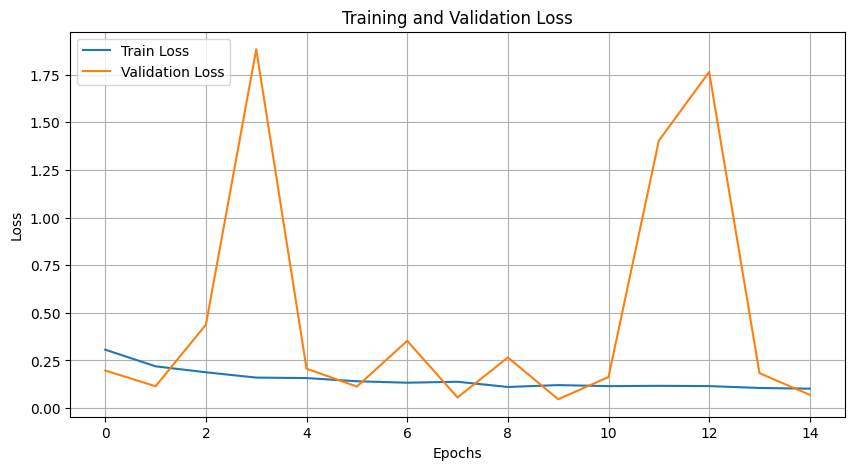

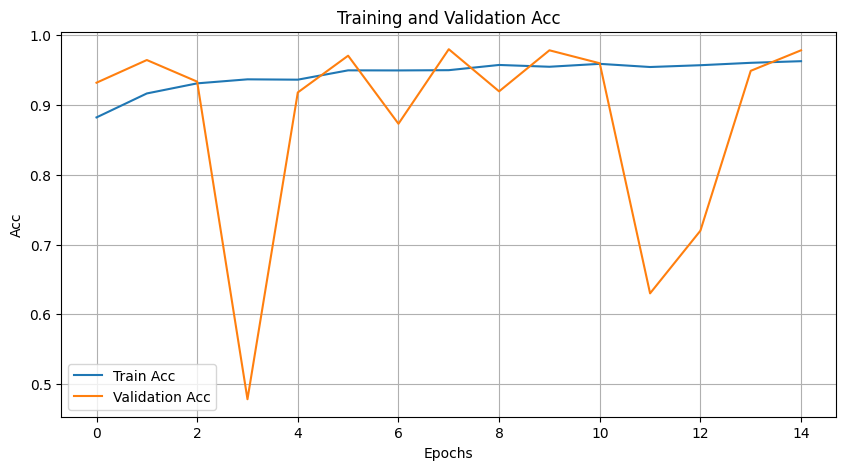

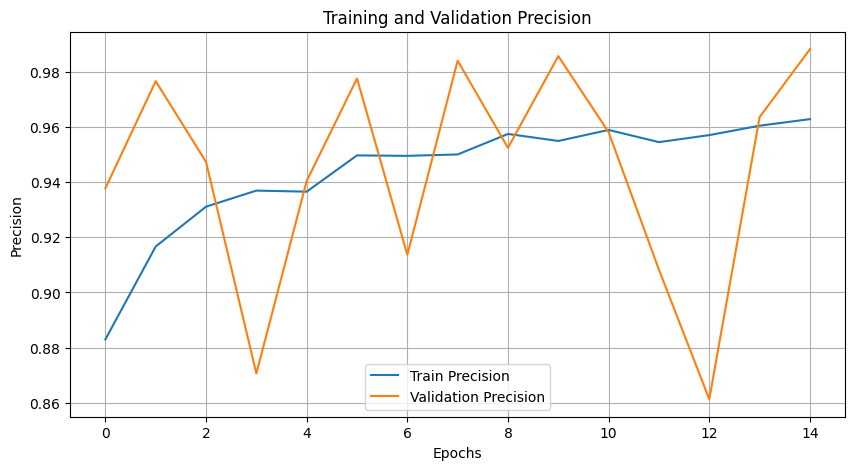

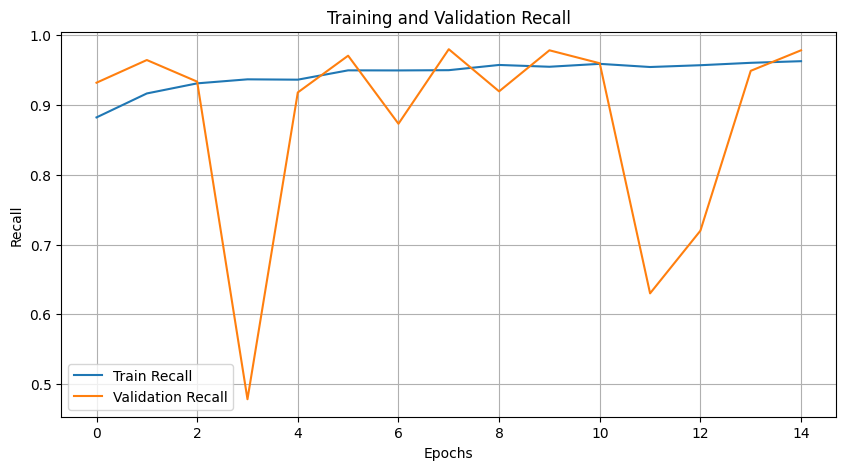

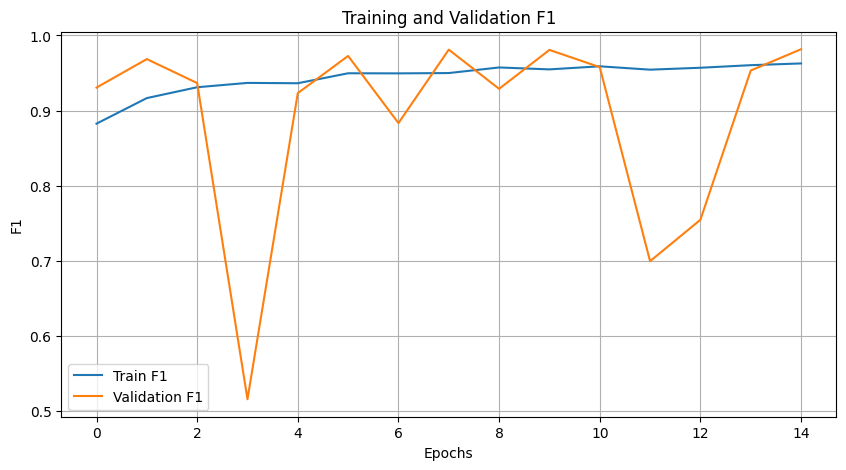

In [33]:
import matplotlib.pyplot as plt

# Function to plot and save metrics
def plot_metrics(metrics, output_dir):
    for metric in ['loss', 'acc', 'precision', 'recall', 'f1']:
        plt.figure(figsize=(10, 5))

        # Plot training and validation metrics
        plt.plot(metrics[f'train_{metric}'], label=f'Train {metric.capitalize()}')
        plt.plot(metrics[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

        # Save the figure
        plt_path = f"{output_dir}/training_validation_{metric}.png"
        plt.savefig(plt_path)

        # Show the plot
        plt.show()

# Directory in Google Drive to save the plots
output_dir = "/content/drive/MyDrive/training_plots"

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Plot and save all metrics
plot_metrics(metrics, output_dir)


KeyError: 'test_loss'

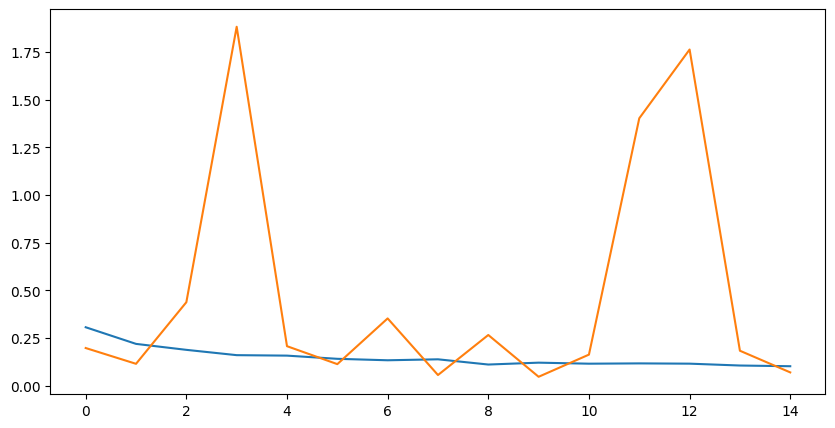

In [37]:
import matplotlib.pyplot as plt

# Function to plot and save metrics
def plot_metrics(metrics, output_dir):
    for metric in ['loss', 'acc', 'precision', 'recall', 'f1']:
        plt.figure(figsize=(10, 5))

        # Plot training and validation metrics
        plt.plot(metrics[f'train_{metric}'], label=f'Train {metric.capitalize()}')
        plt.plot(metrics[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

        # Plot test metric (if available)
        if metrics[f'test_{metric}']:
            plt.axhline(y=metrics[f'test_{metric}'][0], color='r', linestyle='--', label=f'Test {metric.capitalize()}')

        plt.title(f'Training, Validation, and Test {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

        # Save the figure
        plt_path = f"{output_dir}/training_validation_test_{metric}.png"
        plt.savefig(plt_path)
        print(f"Saved {metric} plot to {plt_path}")

        # Show the plot
        plt.show()

# Directory in Google Drive to save the plots
output_dir = "/content/drive/MyDrive/training_plots"

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Plot and save all metrics including test
plot_metrics(metrics, output_dir)


Saved loss plot to /content/drive/MyDrive/training_plots/training_validation_test_loss.png


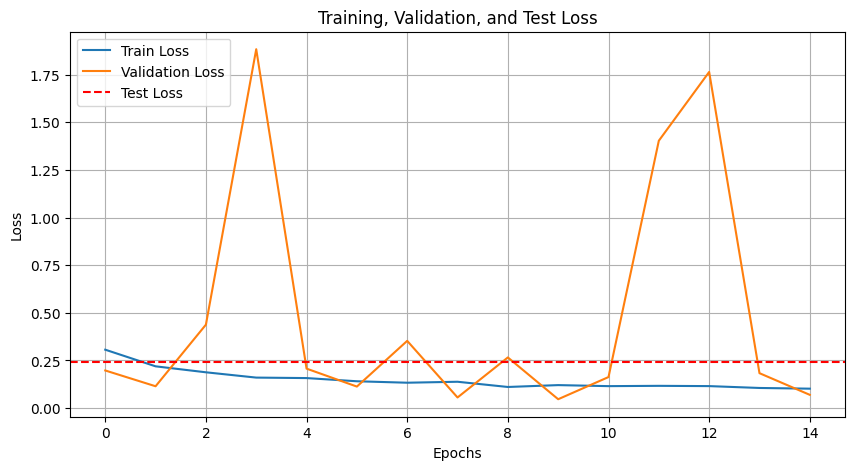

Saved acc plot to /content/drive/MyDrive/training_plots/training_validation_test_acc.png


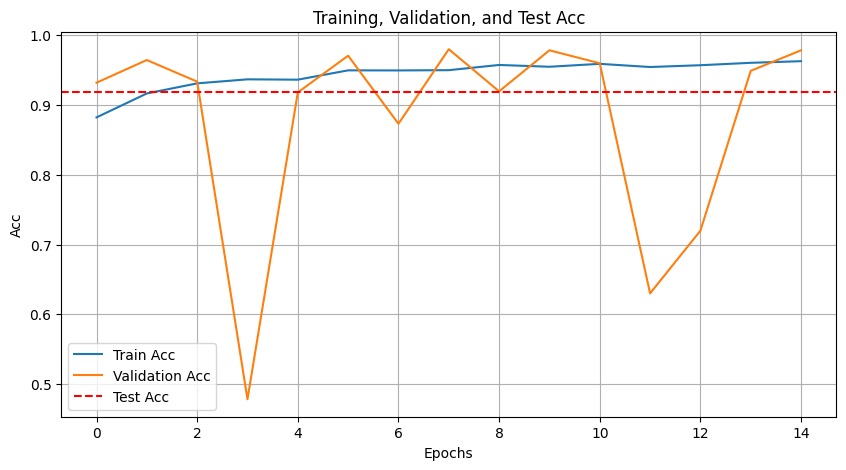

Saved precision plot to /content/drive/MyDrive/training_plots/training_validation_test_precision.png


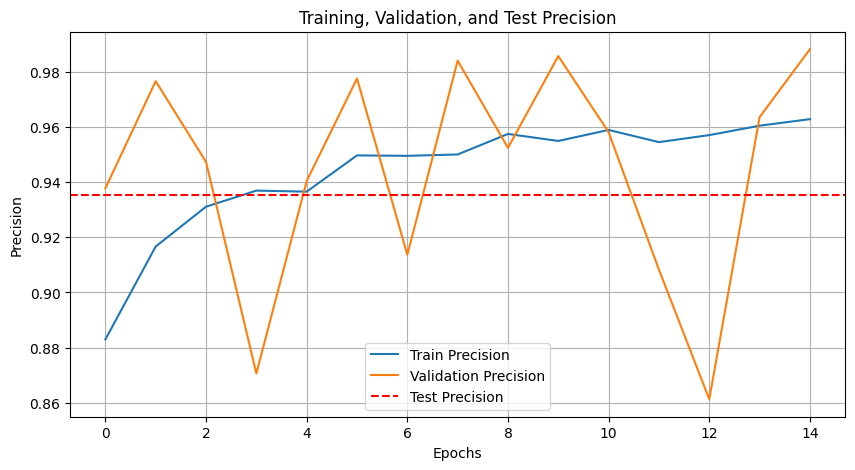

Saved recall plot to /content/drive/MyDrive/training_plots/training_validation_test_recall.png


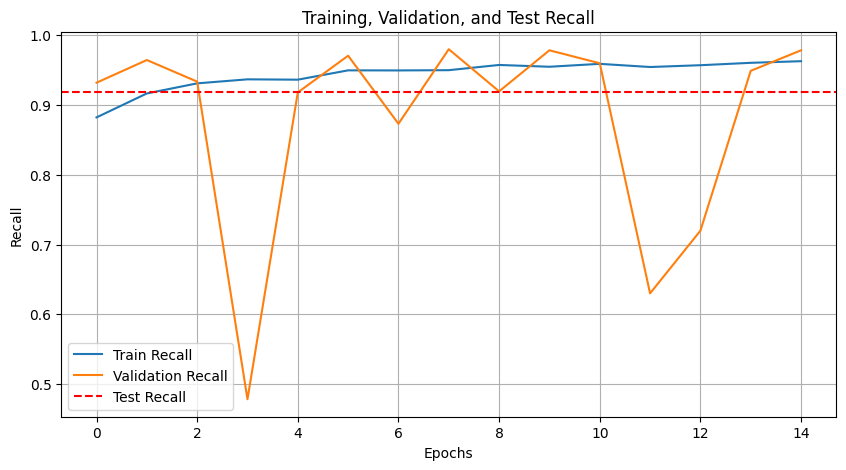

Saved f1 plot to /content/drive/MyDrive/training_plots/training_validation_test_f1.png


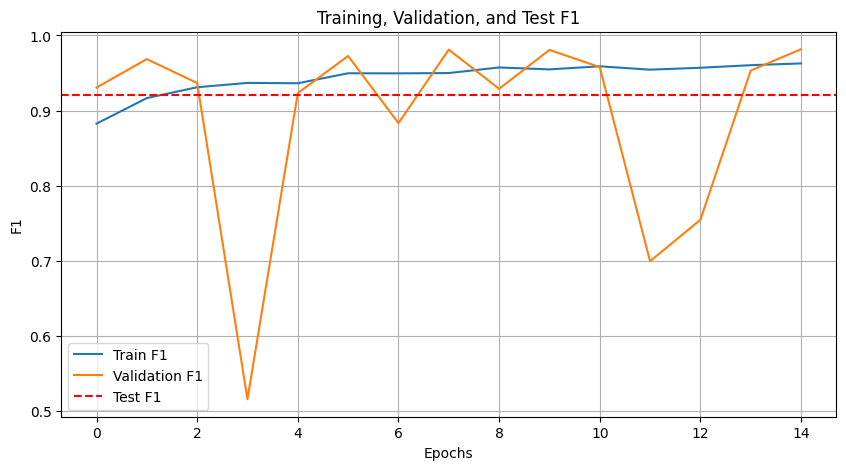

In [38]:
import matplotlib.pyplot as plt
import os

# Function to plot and save metrics
def plot_metrics(metrics, metrics_test, output_dir):
    for metric in ['loss', 'acc', 'precision', 'recall', 'f1']:
        plt.figure(figsize=(10, 5))

        # Plot training and validation metrics
        plt.plot(metrics[f'train_{metric}'], label=f'Train {metric.capitalize()}')
        plt.plot(metrics[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

        # Plot the test metric as a horizontal line (since test is evaluated once after training)
        if metrics_test[f'test_{metric}']:
            plt.axhline(y=metrics_test[f'test_{metric}'][0], color='r', linestyle='--', label=f'Test {metric.capitalize()}')

        plt.title(f'Training, Validation, and Test {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

        # Save the figure
        plt_path = f"{output_dir}/training_validation_test_{metric}.png"
        plt.savefig(plt_path)
        print(f"Saved {metric} plot to {plt_path}")

        # Show the plot
        plt.show()

# Directory in Google Drive to save the plots
output_dir = "/content/drive/MyDrive/training_plots"

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Plot and save all metrics
plot_metrics(metrics, metrics_test, output_dir)
